# 용해도 예측
- 물질이 용매에 포화상태까지 녹을 수 있는 한도
- 랜덤 포레스트 모델과 그래프 모델의 성능을 비교한다
- ConvMol을 이해한다


## 존 델라니가 2004년에 발표한 논문 데이터
- featurizer='GraphConv' 옵션으로 각 분자의 SMILES를 그래프 합성곱 모델용으로 선택

- Use MoleculeNet
 - a diverse collection of chemical and molecular data sets
 - use the Delaney solubility data set
 - log(solubility) measured in moles/liter.

# Import

In [1]:
!pip install deepchem
import deepchem as dc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 14.7 MB/s 
     |████████████████████████████████| 36.8 MB 1.2 MB/s 


In [8]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

import tempfile
from itertools import islice
from IPython.display import Image, display
from deepchem.utils.data_utils import load_from_disk  

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Modeling


- 분자 용해도를 예측하는 모델을 만들어 약물과 유사한 화합물의 용해도를 예측하는 데 사용할 수 있다

1. 데이터 준비
2. 특성 선택
3. 모델 선택
4. 학습과 성능 평가

# 데이터

- csv 데이터 세트를 다운로드 한다 (SMILES 문자열, 예측된 수성 용해도 및 많은 분자특성을 포함)
- 예시

<table style="width:100%">
  <tr>
    <th> Compound ID </th>
    <th> ESOL predicted log solubility (mols/liter) </th> 
      <th> Minimum Degree </th> 
      <th> Molecular Weight </th>
      <th> # H-Bond Donors </th>
      <th> # Rings </th>
      <th> # Rotatable Bonds </th>
      <th> Polar Surface Area </th>
      <th> Measured log solubility (mols/liter) </th>
      <th> smiles </th>
  </tr>
  <tr>
    <td>benzothiazole</td>
    <td>-2.733</td> 
    <td>2</td>
      <td> 135.191 </td>
      <td> 0 </td>
      <td> 2 </td>
      <td> 0 </td>
      <td> 12.89 </td>
      <td> -1.5 </td>
      <td> c2ccc1scnc1c2 </td> 
  </tr>

</table>

- 여기서는 `SMILEs` 와 `Measured log-solubility in mols/liter`만 사용한다

In [9]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2022-08-19 02:00:51--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv.1’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.005s  

2022-08-19 02:00:51 (20.4 MB/s) - ‘delaney-processed.csv.1’ saved [96699/96699]



In [10]:
# pandas read.csv와 같은 역할을 수행하는 함수 (데이터프레임으로 읽는다)
from deepchem.utils.data_utils import load_from_disk  

dataset = load_from_disk("delaney-processed.csv")
print(dataset.shape)
dataset.columns

(1128, 10)


Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')

In [11]:
dataset[:5]

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


## EDA

- RDkit을 사용하여 화합물을 시각화

In [12]:
# 이미지 파일들을 출력하는 함수
def display_images(filenames):
    for file in filenames:
      display(Image(file))

# Mol 객체들을 입력으로 받아 이미지 파일을 만들고 파일 리스트를 리턴한다
# test0.png, test1.png, test2.png, test3.png, test4.png 등으로 생성

def mols_to_pngs(mols, basename="test"):
    filenames = []
    for i, mol in enumerate(mols):
        # filename = "%s%d.png" % (basename, i)
        filename = basename+str(i)+".png"
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

- dataset의 상위 N개 분자들을 시각화

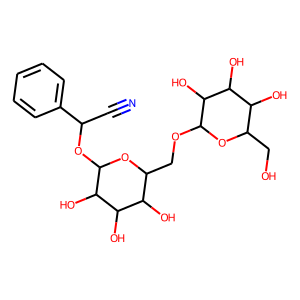

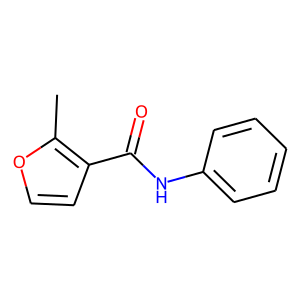

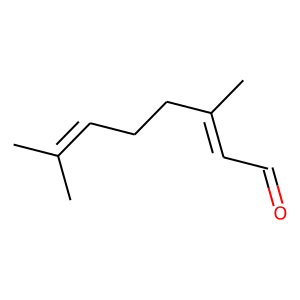

In [13]:
num_to_display = 3
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["smiles"]))
    
display_images(mols_to_pngs(molecules))

### 하나의 이미지만 출력할 때


<class 'rdkit.Chem.rdchem.Mol'>


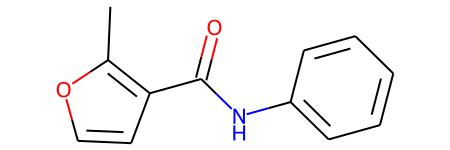

In [14]:
print(type(Chem.MolFromSmiles(dataset["smiles"][1])))
Chem.MolFromSmiles(dataset["smiles"][1])

In [15]:
# Mol 객체
molecules

In [16]:
# png 그림 파일명
mols_to_pngs(molecules)

['test0.png', 'test1.png', 'test2.png']

In [17]:
molecules

- 타겟 변수 `logS` 분포 보기

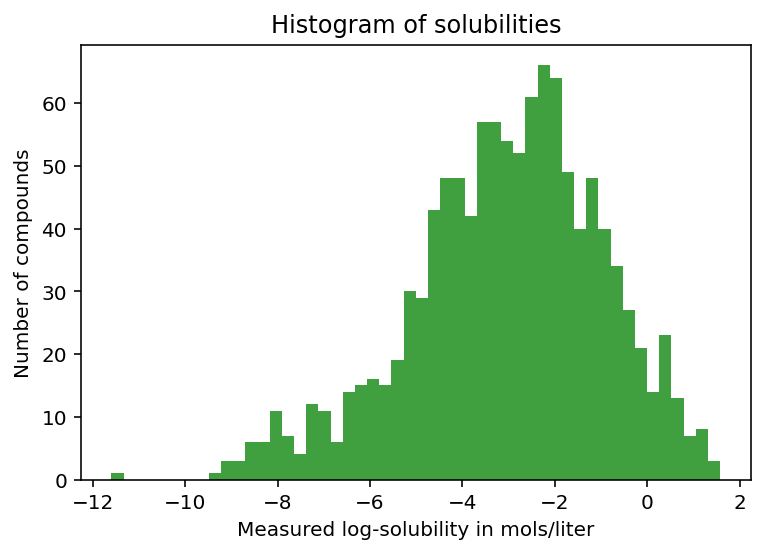

In [18]:
solubilities = np.array(dataset["measured log solubility in mols per litre"])
plt.hist(solubilities, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
plt.title('Histogram of solubilities')
plt.show()

## 특성화 (Featurization)

- 화합물 특성을 어떻게 표현할지를 정해야 한다. 즉, `featurization`(특성화)을 수행한다
- `SMILES`형식으로 부터 특성 벡터를 생성하는 방법으로 `ECPF`를 사용
- CSVLoader 클래스의 featurize()를 사용한다
- `dc.feat` 모듈에서 제공한다
 - `CircularFingerprint` 클래스 제공

In [19]:
featurizer = dc.feat.CircularFingerprint(size=1024)
loader = dc.data.CSVLoader(
      tasks=["measured log solubility in mols per litre"], feature_field="smiles",
      featurizer=featurizer)
data_FP = loader.create_dataset("delaney-processed.csv")

In [20]:
print(data_FP.X.shape)
data_FP.y[:5]

(1128, 1024)


array([[-0.77],
       [-3.3 ],
       [-2.06],
       [-7.87],
       [-1.33]])

## 데이터 분할

In [21]:
#dc.splits에서 다양한 분할 방법을 제공
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(data_FP)

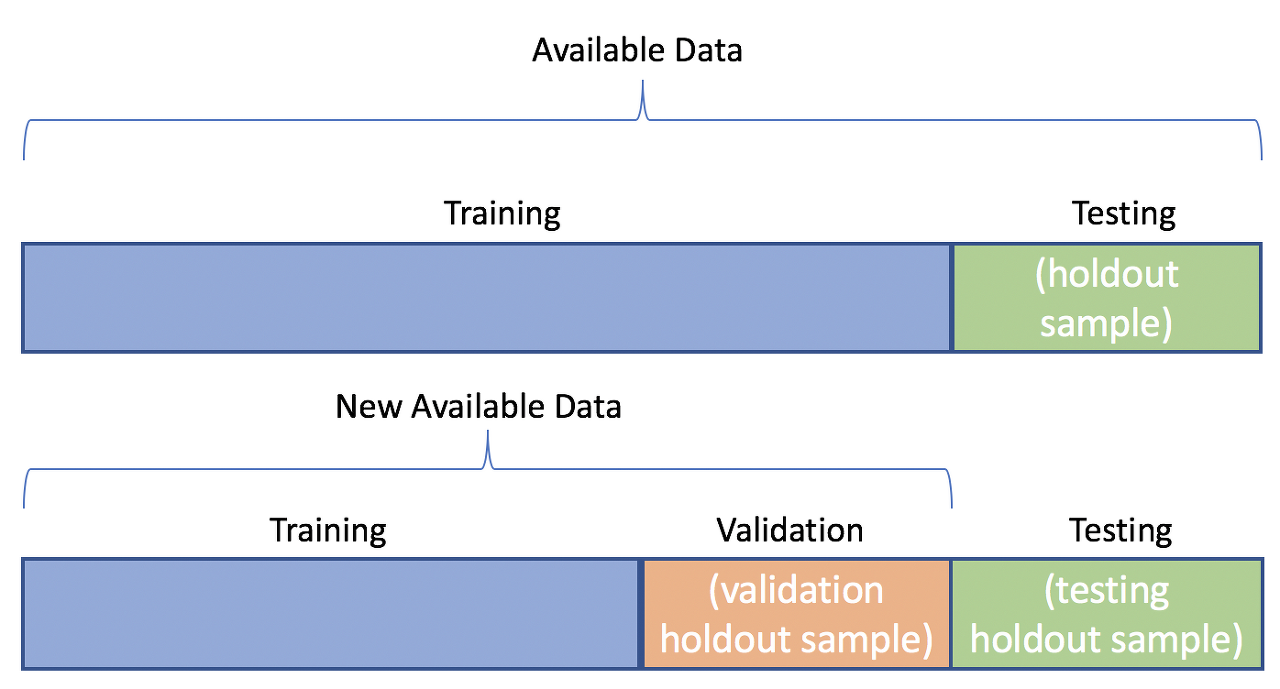

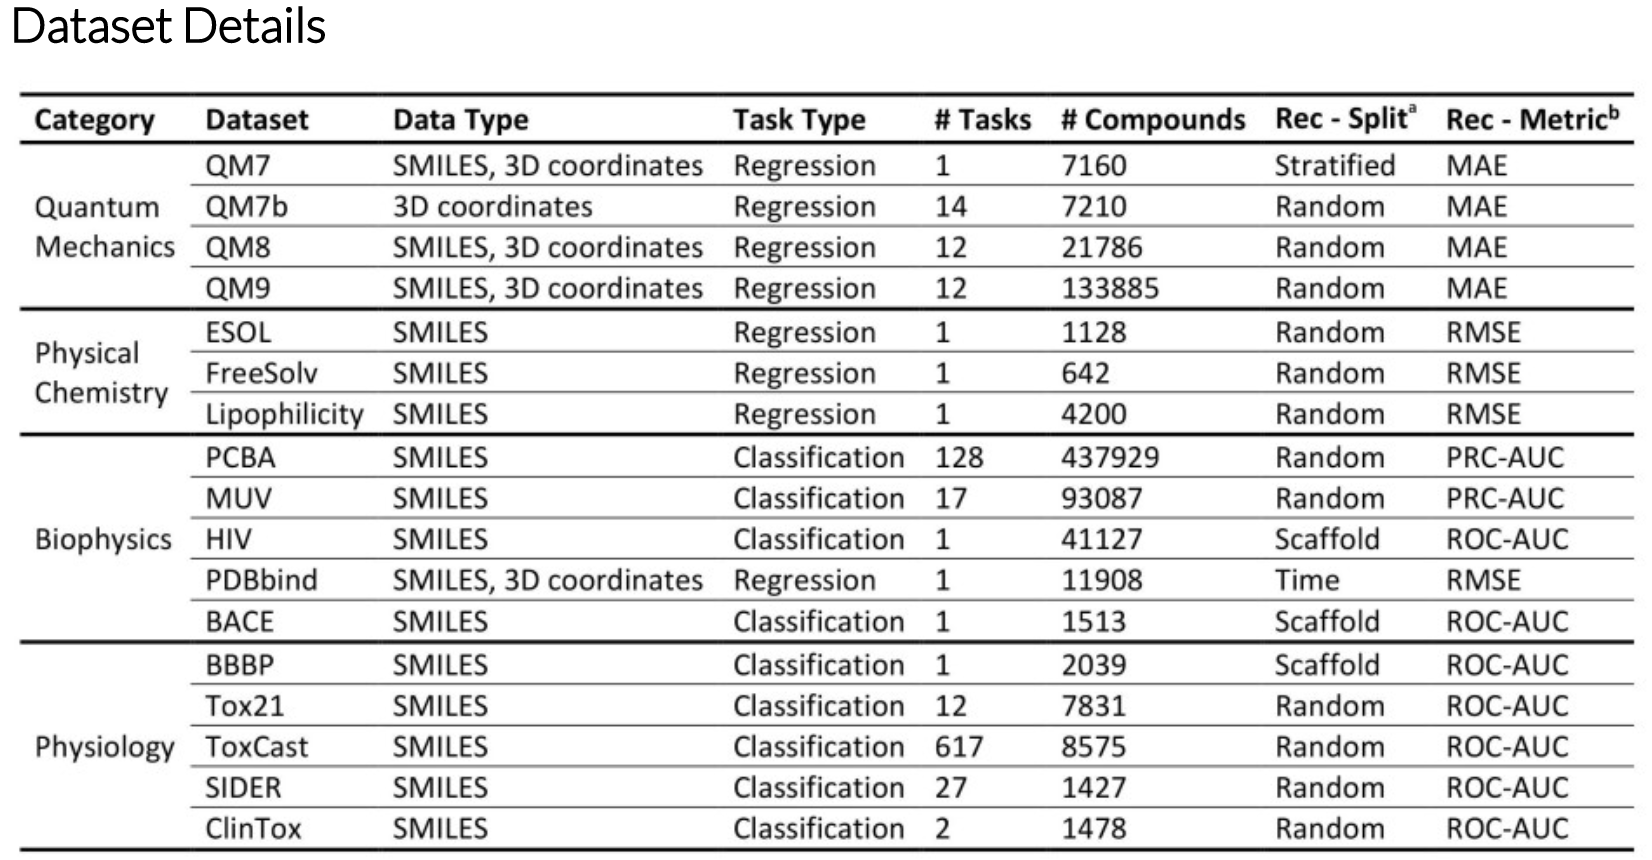

In [22]:
train_dataset.ids[:5]

array(['CC(C)=CCCC(C)=CC(=O)', 'CCCC=C', 'CCCCCCCCCCCCCC', 'CC(C)Cl',
       'CCC(C)CO'], dtype=object)

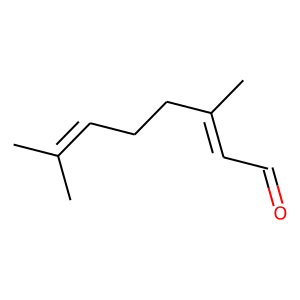

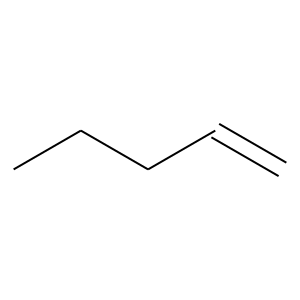

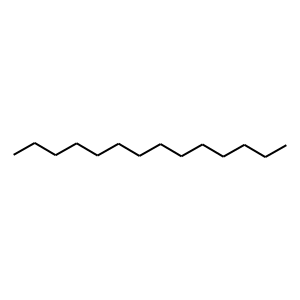

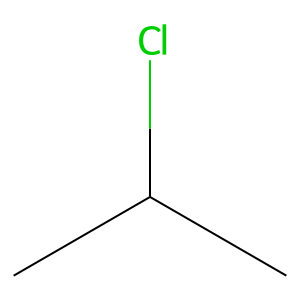

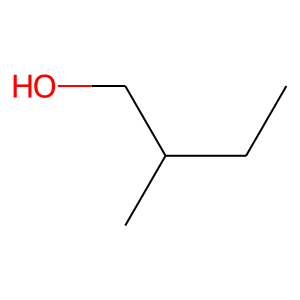

In [23]:
#앞서 사용한 시각화 함수를 사용하여 Train/Test set의 Mol object의 차이점 확인
train_mols = [Chem.MolFromSmiles(compound)
              for compound in train_dataset.ids]
display_images(mols_to_pngs(train_mols[:5], basename="train"))


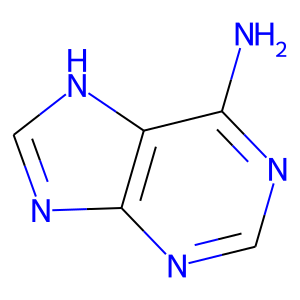

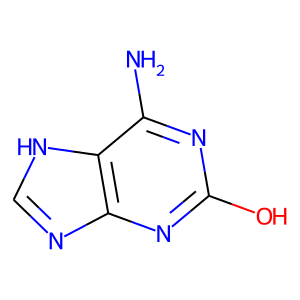

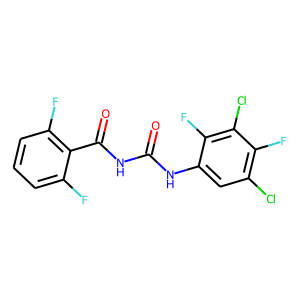

In [24]:
#앞서 사용한 시각화 함수를 사용하여 Train/Test set의 Mol object의 차이점 확인
valid_mols = [Chem.MolFromSmiles(compound)
              for compound in valid_dataset.ids]
display_images(mols_to_pngs(valid_mols[:3], basename="vaild"))


In [25]:
test_mols = [Chem.MolFromSmiles(compound)
              for compound in test_dataset.ids]
# display_images(mols_to_pngs(test_mols[:5], basename="test"))

In [26]:
# 표준 스케일링 수행
transformers = [
dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

- `deepchem`은 많은 기계 학습 모델 클래스를 제공
 - 특히, `deepChem`은 `SklearnModel`에서 사용할 수 있는 모든 기계 학습 모델을 포함하는 편리한 클래스인 `scikit-learn`을 제공

- 랜덤 포레스트 회귀 모델 사용

# RandomForest 모델

In [27]:
from sklearn.ensemble import RandomForestRegressor
sklearn_model = RandomForestRegressor()
# sklearn 모델을 deepchem models로 변경
model = dc.models.SklearnModel(sklearn_model)
#train_dataset에 포함된 X, w, y값을 사용하여 모델 훈련
model.fit(train_dataset)

## 성능 평가
- `deepchem`은 `Evaluator` 객체의 `compute_model_performance()`로 평가

In [28]:
from deepchem.utils.evaluate import Evaluator
metric1 = dc.metrics.Metric(dc.metrics.r2_score)
metric2 = dc.metrics.Metric(dc.metrics.rms_score)

evaluator = Evaluator(model, valid_dataset, transformers)
scores = evaluator.compute_model_performance([metric1, metric2])
print(scores)

{'r2_score': 0.16359758220195308, 'rms_score': 3.736463794777557}


- 하이퍼 파라미터 튜닝 수행

- model_dir은 dc.models.SklearnModel 함수의 인자로 다른 디렉토리에 생성한 모델이 있는 경우에 불러오기 위한 인자임

In [29]:
def rf_model_builder(n_estimators, max_features, max_depth, model_dir):
  sklearn_model = RandomForestRegressor(
      n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
  return dc.models.SklearnModel(sklearn_model, model_dir)

#하이퍼파라미터의 여러개의 값 설정 
params_dict = {
    "n_estimators": [100],
    "max_features": [0.1, 0.15, 0.2],
    "max_depth" : [15, 17, 19, 21]
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)

# 최고 성능의 모델, 최고 성능의 하이퍼파라미터, 모든 결과를 리턴한다
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, metric, transformers)

In [30]:
#최고 성능을 보이는 모델 하이퍼파라미터 출력
print(best_rf)
#탐색할때 사용한 하이퍼파라미터의 최적 값 출력
print(best_rf_hyperparams)
#모든 탐색 성능 평가 결과 출력
print(all_rf_results)

{'n_estimators': 100, 'max_features': 0.1, 'max_depth': 19}
{'_max_depth_15_max_features_0.100000_n_estimators_100': 0.24198046194048284, '_max_depth_17_max_features_0.100000_n_estimators_100': 0.2292035503432096, '_max_depth_19_max_features_0.100000_n_estimators_100': 0.2507309080943423, '_max_depth_21_max_features_0.100000_n_estimators_100': 0.22291388637416953, '_max_depth_15_max_features_0.150000_n_estimators_100': 0.19755622608096546, '_max_depth_17_max_features_0.150000_n_estimators_100': 0.22367525351881368, '_max_depth_19_max_features_0.150000_n_estimators_100': 0.184271756341581, '_max_depth_21_max_features_0.150000_n_estimators_100': 0.22711888501010602, '_max_depth_15_max_features_0.200000_n_estimators_100': 0.22575810925705964, '_max_depth_17_max_features_0.200000_n_estimators_100': 0.18892428962924168, '_max_depth_19_max_features_0.200000_n_estimators_100': 0.218221329353133, '_max_depth_21_max_features_0.200000_n_estimators_100': 0.21867208128286197}


- 최대 R2로 0.25 정도를 얻었다

# 그래프 컨볼루션 모델

In [31]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [ ]:
train_dataset.X[0]

In [ ]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)
model.fit(train_dataset, nb_epoch=100)
metric1 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric1, metric2], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric1, metric2], transformers))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_14:0", shape=(357,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_13:0", shape=(357, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_17:0", shape=(960,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/R

Training set score: {'pearson_r2_score': 0.9208128047636036, 'r2_score': 0.8264287679412623}
Test set score: {'pearson_r2_score': 0.6615075084473844, 'r2_score': 0.5400464380056282}


- R2 점수로 0.54을 얻었다

In [ ]:
solubilities = model.predict_on_batch(test_dataset.X)
for molecule, solubility, test_solubility in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(solubility, test_solubility, molecule)

[-1.5510707] [-1.60114461] c1cc2ccc3cccc4ccc(c1)c2c34
[0.5275386] [0.20848251] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.47662422] [-0.01602738] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-1.8004398] [-2.82191713] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.4083804] [-0.52891635] C1=Cc2cccc3cccc1c23
[1.4209346] [1.10168349] CC1CO1
[-0.21532029] [-0.88987406] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-1.0147501] [-0.52649706] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-1.3387764] [-0.76358725] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[0.03746831] [-0.64020358] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 
[-0.13175446] [-0.38569452] COc2c1occc1cc3ccc(=O)oc23 
[0.38931447] [-0.62568785] CN2C(=C(O)c1ccccc1S2(=O)=O)C(=O)Nc3ccccn3 
[-0.15082362] [-0.39585553] Cc3cc2nc1c(=O)[nH]c(=O)nc1n(CC(O)C(O)C(O)CO)c2cc3C
[-0.6889084] [-2.05306753] c1ccc(cc1)c2ccc(cc2)c3ccccc3
[-0.2941002] [-0.29666474] CC34CC(=O)C1C(CCC2=CC(=O)CCC12C)C3CCC4(=O) 
[-0.366429] [-0.73213651] c1ccc2c(c1)sc3ccccc23
[-0.7010779] [-1.27744393] CC23Cc1cnoc1

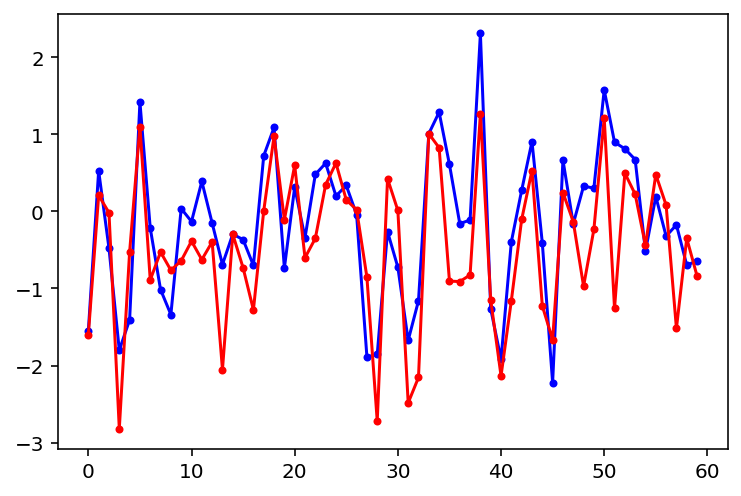

In [ ]:
# 60개의 테스트 샘플만 비교했다
plt.plot(solubilities[:60], "b.-")
plt.plot(test_dataset.y[:60], "r.-")

### 임의의 샘플에 적용해보기

In [ ]:
from rdkit import Chem

smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)
predicted_solubility = model.predict_on_batch(x)
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)


Molecule: COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C
Predicted solubility: [-0.73417765]

Molecule: CCOC(=O)CC
Predicted solubility: [1.6613564]

Molecule: CSc1nc(NC(C)C)nc(NC(C)C)n1
Predicted solubility: [0.09456187]

Molecule: CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1
Predicted solubility: [-0.03003942]

Molecule: Cc1cc2ccccc2cc1C
Predicted solubility: [-0.2103419]


## ConvMol 이해

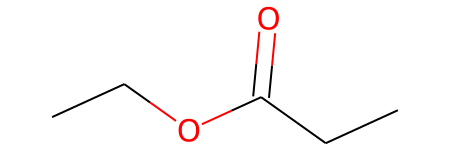

In [ ]:
# 위의 샘플에서 두번째 분자
Chem.MolFromSmiles("CCOC(=O)CC")

In [ ]:
x[1].atom_features.shape

(7, 75)

In [ ]:
x[1].get_atom_features()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0.

In [ ]:
x[1].get_adjacency_list()

[[3], [6], [5], [0, 4], [3, 6], [6, 2], [4, 1, 5]]

In [ ]:
x[1].get_deg_adjacency_lists()

[array([], shape=(0, 0), dtype=int32), array([[3],
        [6],
        [5]], dtype=int32), array([[0, 4],
        [3, 6],
        [6, 2]], dtype=int32), array([[4, 1, 5]], dtype=int32), array([], shape=(0, 4), dtype=int32), array([], shape=(0, 5), dtype=int32), array([], shape=(0, 6), dtype=int32), array([], shape=(0, 7), dtype=int32), array([], shape=(0, 8), dtype=int32), array([], shape=(0, 9), dtype=int32), array([], shape=(0, 10), dtype=int32)]

In [ ]:
for i in range(4):
  print(x[1].get_deg_adjacency_lists()[i])

[]
[[3]
 [6]
 [5]]
[[0 4]
 [3 6]
 [6 2]]
[[4 1 5]]


In [ ]:
x[1].get_deg_slice()

array([[0, 0],
       [0, 3],
       [3, 3],
       [6, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)

### 임의의 ConvMol 생성

In [ ]:
atom_features = np.array([[20, 21, 22, 23],
                          [24, 25, 26, 27],
                          [28, 29, 30, 31],
                          [32, 33, 34, 35]])
adj_list = [[1, 2], [0, 3], [0, 3], [1, 2]]
mol = dc.feat.mol_graphs.ConvMol(atom_features, adj_list)


In [ ]:
mol.atom_features

array([[20, 21, 22, 23],
       [24, 25, 26, 27],
       [28, 29, 30, 31],
       [32, 33, 34, 35]])

In [ ]:
mol.get_adjacency_list()

[[1, 2], [0, 3], [0, 3], [1, 2]]

In [ ]:
mol.get_deg_slice()

array([[0, 0],
       [0, 0],
       [0, 4],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)